In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

import iisignature
from tqdm import tqdm

In [2]:
from normalizers import *

class Path():
    def __init__(self, vals, dims, reps=range(1, 7), norm_vals=True):
        self.vals = vals.reset_index(drop=True, inplace=False)
        self.dims = dims
        if norm_vals:
            self.vals = better_normalize(self.vals, reps, dims=self.dims)

class DB5Path(Path):
    def __init__(self, vals, exercise, repetition, dims=None):
        if dims is None:
            temp_dims = vals.shape[1] - 2
        else:
            temp_dims = dims
        super().__init__(vals, temp_dims)
        self.exercise = exercise
        self.repetition = repetition
    
    def naive_padding(self, length) -> np.array:
        tempdf = pd.DataFrame(np.random.standard_normal(size = (length, self.dims)))
        tempdf['stimulus'] = pd.Series(np.ones(length) * self.exercise)
        tempdf['repetition'] = pd.Series(np.ones(length) * self.repetition)
        return tempdf
    
    def get_windows(self, window_size, overlap, use_padding=False) -> np.array:
        """
        returns a list of dataframes
        """
        begin = 0
        ans = []
        n = len(self.vals)
        while(begin < n):
            if (begin + window_size < n):
                ans.append(self.vals[begin:begin + window_size])
            else:
                # need to pad it out
                if use_padding:
                    overflow = (n - begin) % window_size
                    ans.append(pd.concat([self.vals[begin:], self.naive_padding(window_size - overflow)], ignore_index=True))
                else:
                    pass  # other option is to drop the last bit
            begin += window_size - overlap
        return ans


In [3]:
def shift_stim(stims : pd.Series, shift : int):
    # shifts all stimuli by an amount
    stims[stims != 0] += shift
    return stims

def load_subject(data_paths, col='emg'):
    df = pd.DataFrame([])
    tot_stim = 0
    for i, data_path in enumerate(data_paths):
        mat = sio.loadmat(data_path)
        if i == 0:
            df = pd.DataFrame(mat[col])
            df['stimulus'] = mat['restimulus']
            df['repetition'] = mat['repetition']
        else:
            df2 = pd.DataFrame(mat[col])
            df2['stimulus'] = shift_stim(pd.DataFrame(mat['restimulus']), tot_stim)
            df2['repetition'] = mat['repetition']
            df = pd.concat([df, df2], ignore_index=True)
        tot_stim += len(np.unique(mat['restimulus'])) - 1
    return df

In [4]:
subjects = range(1, 11)
exercises = [1]
root = './signatures_data/'
df = pd.DataFrame([])
for subject in subjects:
    data_paths = [os.path.join(root, f"s{subject}/S{subject}_E{exercise}_A1.mat") for exercise in exercises]
    cur_df = load_subject(data_paths, col='glove')
    df = pd.concat([df, cur_df], ignore_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,stimulus,repetition
0,81.193825,-25.613001,17.336512,-6.904053,12.986491,18.831488,1.902927,19.194145,6.613120,-22.310045,...,-3.972004,27.264063,21.547808,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0
1,81.147217,-25.613001,17.336512,-6.949311,12.898676,18.659233,1.944808,19.242105,6.309145,-22.280998,...,-3.901077,27.264063,21.477554,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0
2,81.100609,-25.613001,17.336512,-6.994570,12.810861,18.486980,1.986689,19.290066,6.005171,-22.251951,...,-3.830149,27.264063,21.407303,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0
3,81.054001,-25.613001,17.336512,-7.039829,12.723045,18.314728,2.028570,19.338028,5.701196,-22.222904,...,-3.759222,27.264063,21.337051,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0
4,81.007385,-25.613001,17.336512,-7.085087,12.635230,18.142475,2.070451,19.385988,5.397222,-22.193857,...,-3.688294,27.264063,21.266798,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0


In [5]:
def compute_log_signature(path, depth, dims=None):
    if dims is None:
        dims = path.shape[1] # take second, assumes (timesteps, dims)
    s = iisignature.prepare(dims, depth)
    return iisignature.logsig(path, s)

In [8]:
repetitions = [1, 2, 3, 4, 5, 6]
stims = [1, 3]
train_set = [1, 3, 4, 6]
test_set = [2, 5]
train_windows = []
test_windows = []
for stimulus in stims:
    for repetition in repetitions:
        dbpth = DB5Path(df[(df.stimulus == stimulus) & (df.repetition == repetition)], stimulus, repetition)
        if repetition in train_set:
            train_windows += dbpth.get_windows(window_size=200, overlap=100)
        elif repetition in test_set:
            test_windows += dbpth.get_windows(window_size=200, overlap=100)
train_x, train_y = splitxy(train_windows, [5,8,10], ['stimulus'])
test_x, test_y = splitxy(test_windows, [5,8,10], ['stimulus'])

In [9]:
len(train_windows), len(test_windows), train_x.shape, train_y.shape


(692, 336, (692, 200, 3), (692,))

In [10]:
def splitxy(dfs : list, x_cols, y_col):
    x = []
    y = []
    for df in dfs:
        x.append(df[x_cols].to_numpy())
        y.append(df[y_col].to_numpy()[0]) # assume everything is of the same class
    return np.array(x), np.array(y).reshape(-1)

train_x, train_y = splitxy(train_windows, range(16), ['stimulus'])
test_x, test_y = splitxy(test_windows, range(16), ['stimulus'])

train_signatures = []
for window in tqdm(train_x):
    train_signatures.append(compute_log_signature(window, depth=4))
test_signatures = []
for window in tqdm(test_x):
    test_signatures.append(compute_log_signature(window, depth=4))
train_signatures = np.array(train_signatures)
test_signatures = np.array(test_signatures)

100%|██████████| 336/336 [00:28<00:00, 11.83it/s]


In [11]:
def accuracy(pred, true):
    assert len(pred) == len(true), "check lengths match"
    return np.sum((pred == true)) / len(pred)

assert accuracy(np.array([1, 1, 1, 2]), np.array([1, 2, 1, 2])) == 0.75

In [12]:
print(train_signatures.shape, train_y.shape)
print(test_signatures.shape, test_y.shape)

(692, 17816) (692,)
(336, 17816) (336,)


In [11]:
train_signatures[0, :10], train_y[0]

(array([ 0.15287352, -0.15799403,  0.0984855 ,  0.068694  ,  0.80948655,
         1.84939927,  0.39183229,  0.05124822, -0.09199243,  0.33404976]),
 1)

In [16]:
from sklearn.neural_network import MLPClassifier

In [75]:
mlp = MLPClassifier(                
                solver="lbfgs",
                random_state=1,
                max_iter=2000,
                early_stopping=True,
                alpha=1e-3,
                hidden_layer_sizes=[50, 50,], warm_start=True)

mlp.fit(train_signatures, train_y)

MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=[50, 50],
              max_iter=2000, random_state=1, solver='lbfgs', warm_start=True)

In [76]:
train_pred = mlp.predict(train_signatures)
print("training set accuracy:", accuracy(train_pred, train_y))

training set accuracy: 0.9985549132947977


In [77]:
pred = mlp.predict(test_signatures)
accuracy(pred, test_y)

0.8869047619047619

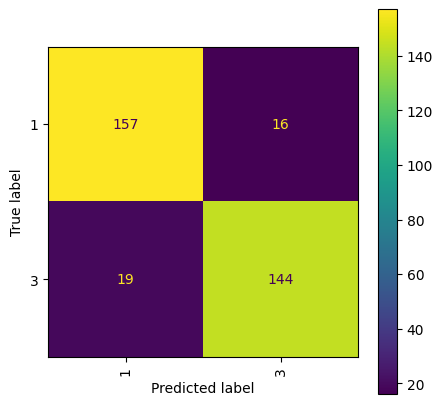

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_y, pred)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(cm,
                                    display_labels=stims).plot(ax=ax,
                                                                       xticks_rotation="vertical")

In [14]:
import torch 

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class LinearClassifierNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.nn.Module.__init__(self)
        self.linear1 = torch.nn.Linear(input_dim, 2048)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.output = torch.nn.Linear(2048, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        x = self.output(x)
        return x

Device: cuda:0


In [15]:
tsig, tlabel = torch.Tensor(train_signatures).to(device), torch.Tensor(train_y).to(device)


In [16]:
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 20

model = LinearClassifierNet(input_dim=train_signatures.shape[1], output_dim=1).to(device) # go from signature item to corresponding label 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for e in range(EPOCHS): 
    # train eval
    model.train()
    c_loss = 0.0 
    for idx in tqdm(range(tsig.shape[0]), desc=f"Epoch {e}", leave=False): 
    #for i, data in tqdm(enumerate(tsig), desc=f"Epoch {e}", leave=False): 
        inputs, label = tsig[idx], tlabel[idx].to(dtype=torch.long)
        print(inputs.shape, label)
        optimizer.zero_grad() 
        output = model(inputs) 
        loss = loss_fn(output, label) 
        loss.backward() 
        optimizer.step() 
        c_loss += loss.item() 
    
    print(f"train loss: {c_loss}")

    # test eval 
    


Epoch 0:   0%|          | 0/692 [00:00<?, ?it/s]

torch.Size([17816]) tensor(1, device='cuda:0')


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

../aten/src/ATen/native/cuda/Loss.cu:199: nll_loss_forward_reduce_cuda_kernel_1d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.


In [22]:
tsig[0].shape

torch.Size([17816])